# Sensitivity of trends to current definitions
work on one current at a time

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs, feature
import cmocean as cm
import matplotlib.lines as mlines
import statsmodels.api as sm
from shapely.ops import unary_union
import geopandas as gpd
from shapely.geometry import Point, box

import warnings
warnings.filterwarnings("ignore")

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH).drop(columns=['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0','NO2 (uM)', 'NH4 (uM)', 'Nstar (umol kg-1)', 'PO4 (uM)',
       'SiO4 (uM)', 'Chl (mg m-3)','Carbonate','Aragonite', 'Calcite', 'Cd (nmol kg-1)', 'Co (nmol kg-1)',
       'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)', 'Ni (nmol kg-1)','Zn (nmol kg-1)'])

In [3]:
obs.columns

Index(['time', 'longitude (degrees_east)', 'latitude (degrees_north)',
       'depth (m)', 'pressure (dbar)', 'temperature (degC)',
       'salinity (g kg-1)', 'density (kg m-3)', 'spice', 'sigma0 (kg m-3)',
       'DO (umol kg-1)', 'NO3 (uM)', 'TA (uM)', 'DIC (uM)', 'source',
       'current', 'location', '[TA-DIC] (uM)', 'year', 'month', 'NSdist',
       'EWdist'],
      dtype='object')

In [24]:
##################
# Trends in time #
##################

def plot_ratediff_NS_CI(obs_used,var_string, ax, colour, *,
                        CC = False, n_bins=9, cov_type="HAC", hac_maxlags=1,
                        annual_stat="median", min_obs_per_year=3,
                        min_years=4, min_span_years=10, offset=0):

    ylim_dict = {'spice':[-0.03,0.02], 'temperature (degC)': [-0.12,0.12],
                 'salinity (g kg-1)':[-0.015,0.015], 'DO (umol kg-1)':[-3.7,3.7],
                 'NO3 (uM)':[-1.5,0.5], '[TA-DIC] (uM)':[-10,14]}

    # bin edges/centers/widths
    dist = np.asarray(obs_used['dist'])
    dmin, dmax = -1415, 2950
    edges   = np.linspace(dmin, dmax, n_bins+1)
    centers = 0.5 * (edges[:-1] + edges[1:]) + offset

    slopes      = np.full(n_bins, np.nan)
    lo95        = np.full(n_bins, np.nan)
    hi95        = np.full(n_bins, np.nan)
    year_span   = np.full(n_bins, np.nan)   # NaN => excluded
    n_years_arr = np.full(n_bins, np.nan)

    years_all = np.asarray(obs_used['year'])
    y_all     = np.asarray(obs_used[var_string])

    for i in range(n_bins):
        lo, hi = edges[i], edges[i+1]
        msk = (dist >= lo) & (dist < hi) & np.isfinite(years_all) & np.isfinite(y_all)
        if not np.any(msk):
            continue

        # (1) aggregate to annual values with ≥ min_obs_per_year
        df_bin = pd.DataFrame({
            "year": years_all[msk].astype(float),
            "val":  y_all[msk].astype(float)
        })

        # distinct years and span
        n_years = len(set(df_bin["year"]))
        span = float(df_bin["year"].max() - df_bin["year"].min() + 1)

        if (n_years < min_years) or (span < min_span_years):
            # exclude this bin from both points and bars
            continue

        grp = df_bin.groupby("year", as_index=False).agg(
            n=("val", "size"),
            med=("val", "median"),
            mean=("val", "mean")
        )
        grp = grp[grp["n"] >= min_obs_per_year]
        if grp.empty:
            continue

        n_years_arr[i] = n_years
        year_span[i]   = span

        Y_ann = grp["med"].values if annual_stat == "median" else grp["mean"].values
        X_ann = grp["year"].values

        # (2) OLS with equal weight per year + (3) robust SEs
        X = sm.add_constant(X_ann)
        ols = sm.OLS(Y_ann, X)
        if cov_type == "HAC":
            res = ols.fit(cov_type="HAC", cov_kwds={"maxlags": int(hac_maxlags)})
        else:
            res = ols.fit(cov_type=cov_type)

        slopes[i] = res.params[1]
        ci = res.conf_int(alpha=0.05)
        if ci.shape[0] > 1:
            lo95[i], hi95[i] = ci[1, 0], ci[1, 1]

    # group 1: year_span >= 20 (solid)
    m_long = (np.isfinite(slopes) & np.isfinite(lo95) & np.isfinite(hi95) &
              np.isfinite(year_span) & (year_span >= 20))
    if np.any(m_long):
        yerr = np.vstack([hi95[m_long] - slopes[m_long], slopes[m_long] - lo95[m_long]])
        ax.errorbar(centers[m_long], slopes[m_long], yerr=yerr, fmt='.', ms=7,
                       c=colour,zorder=4)

    # group 2: year_span < 20 (faded)
    m_short = (np.isfinite(slopes) & np.isfinite(lo95) & np.isfinite(hi95) &
               np.isfinite(year_span) & (year_span < 20))
    if np.any(m_short):
        yerr = np.vstack([hi95[m_short] - slopes[m_short], slopes[m_short] - lo95[m_short]])
        ax.errorbar(centers[m_short], slopes[m_short], yerr=yerr, fmt='.', ms=7,
                       c=colour,alpha=0.35,zorder=4)

    ax.set_xlim(dmin, dmax)
    ax.set_xticks([-1000,-500,0,500,1000,1500,2000,2500])
    ax.set_xticklabels(['','-500','','500','','1500','','2500'],rotation=90)
    ax.axhline(0, color='black', lw=1,zorder=3)

    secax = ax.secondary_xaxis('top')
    secax.set_xlim(dmin, dmax)
    secax.set_xticks([-1000,-500,0,500,1000,1500,2000,2500])
    if CC == True:
        secax.set_xticklabels(['','-133.3$^\circ$ E','','43.3$^\circ$ N','','35.2$^\circ$ N','','28.6$^\circ$ N'],rotation=90)
    else:
        secax.set_xticklabels(['','51.0$^\circ$ N','','43.3$^\circ$ N','','35.2$^\circ$ N','','28.6$^\circ$ N'],rotation=90)

    if var_string in ylim_dict:
        ax.set_ylim(ylim_dict[var_string])

    # add lines for JdF, Cape Mendocino, and Point Conception
    # ax.plot([0,0],[-1000,1000],'k--',alpha=0.5) # JdF
    ax.plot([805,805],[-1000,1000],'k--',alpha=0.5) # Cape Mendocino
    ax.plot([1654,1654],[-1000,1000],'k--',alpha=0.5) # Point Conception
    # ax.text(0.34,0.02,'SS',ha='right',va='bottom',transform=ax.transAxes,fontsize=10)
    ax.text(0.65,0.02,'CM',ha='right',va='bottom',transform=ax.transAxes,fontsize=10)
    ax.text(0.82,0.02,'PC',ha='right',va='bottom',transform=ax.transAxes,fontsize=10)
    
    ax.set_zorder(3)
    ax.patch.set_alpha(0)

    return slopes, hi95-slopes, year_span

## CUC
starting with the CUC bc it feels the most straightforward

In [5]:
# the main option for the CUC has already been defined
cuc1 = obs[obs['current'] == 'CUC']
cuc1['dist'] = cuc1.NSdist

# defined as measurements collected over the continental slope, between 25 and 52 N, and within the 26.45-26.6 g/kg isopycnal range
# what makes sense to play around with here is if we confined the isopycnal range more to check that the range I chose isn't too broad
# range 2 = 26.45-26.55
# range 3 = 26.50-26.60

# since these are within the current CUC bounds we can work with the cuc1 dataset
cuc2 = cuc1[(cuc1['sigma0 (kg m-3)']<=26.55)]
cuc3 = cuc1[(cuc1['sigma0 (kg m-3)']>=26.50)]

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

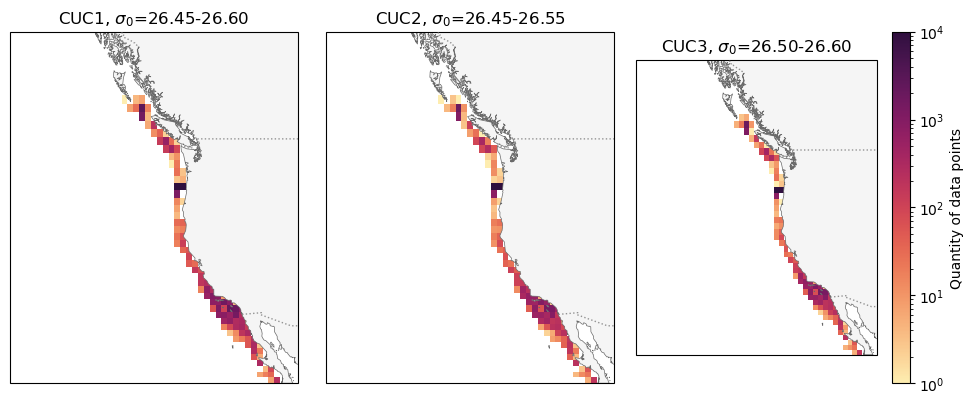

In [ ]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-146, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

########
# CUC1 #
########
ax[0].set_title("CUC1, $\sigma_0$=26.45-26.60")

lon = cuc1['longitude (degrees_east)']
lat = cuc1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


########
# CUC2 #
########
ax[1].set_title("CUC2, $\sigma_0$=26.45-26.55")

lon = cuc2['longitude (degrees_east)']
lat = cuc2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


########
# CUC3 #
########
ax[2].set_title("CUC3, $\sigma_0$=26.50-26.60")

lon = cuc3['longitude (degrees_east)']
lat = cuc3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

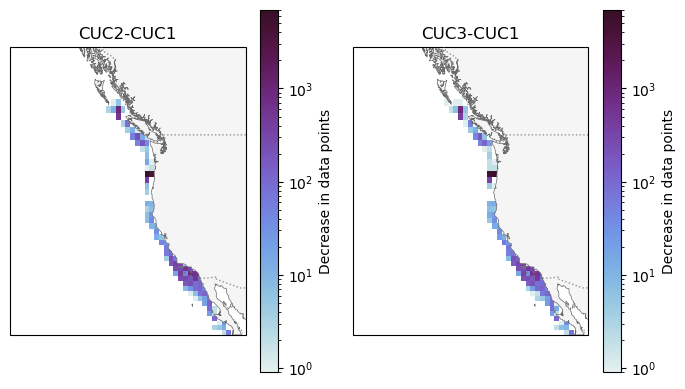

In [7]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 7000,1

#############
# CUC2-CUC1 #
#############
ax[0].set_title("CUC2-CUC1")

hist=hist1-hist2

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

#############
# CUC3-CUC1 #
#############
ax[1].set_title("CUC3-CUC1")

hist=hist1-hist3

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
6) 0.0038 +/- 0.0017, span=73.0 years
7) 0.0022 +/- 0.002, span=73.0 years
8) 0.002 +/- 0.0017, span=73.0 years
range 2 (green)
6) 0.0036 +/- 0.0017, span=73.0 years
7) 0.0026 +/- 0.002, span=73.0 years
8) 0.002 +/- 0.002, span=73.0 years
range 3 (red)
2) 0.0313 +/- 0.0114, span=40.0 years
5) 0.0029 +/- 0.002, span=68.0 years
6) 0.0041 +/- 0.0018, span=73.0 years
7) 0.0023 +/- 0.0015, span=73.0 years


salinity (g kg-1)
range 1 (violet)
6) 0.0009 +/- 0.0004, span=73.0 years
7) 0.0005 +/- 0.0004, span=73.0 years
8) 0.0005 +/- 0.0004, span=73.0 years
range 2 (green)
6) 0.001 +/- 0.0004, span=73.0 years
7) 0.0005 +/- 0.0004, span=73.0 years
8) 0.0006 +/- 0.0004, span=73.0 years
range 3 (red)
2) 0.0023 +/- 0.0015, span=40.0 years
6) 0.0006 +/- 0.0004, span=73.0 years
7) 0.0004 +/- 0.0003, span=73.0 years


spice
range 1 (violet)
6) 0.0013 +/- 0.0005, span=73.0 years
7) 0.0007 +/- 0.0006, span=73.0 years
8) 0.0007 +/- 0.0006, span=73.0 years
range 2 (gree

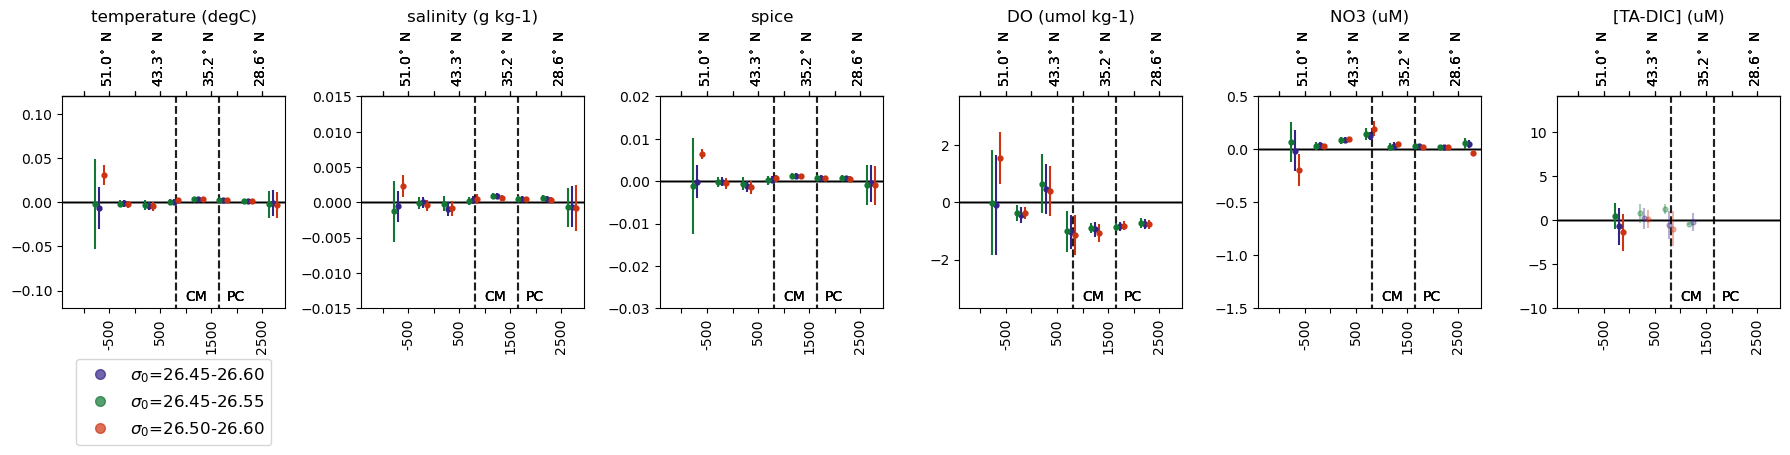

In [39]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(cuc1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(cuc2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(cuc3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')

# # build legend handles    
legend_handles = []
inlegend = ["$\sigma_0$=26.45-26.60",'$\sigma_0$=26.45-26.55','$\sigma_0$=26.50-26.60']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()

## Shelf
Measurements collected over the shelf excluding brackish water (salinity < 31.5 g/kg)
### Depth

In [11]:
# the main option for the shelf has already been defined
shelf1 = obs[obs['current'] == 'shelf']
shelf1['dist'] = shelf1.NSdist

# what makes sense to play around with here is if we removed the surface layers
# small cuttoff = range 2 = 10 m 
# big cuttoff = range 3 = 50 m

# since these are within the current shelf bounds we can work with the shelf1 dataset
shelf2 = shelf1[(shelf1['depth (m)']>10)]
shelf3 = shelf1[(shelf1['depth (m)']>50)]

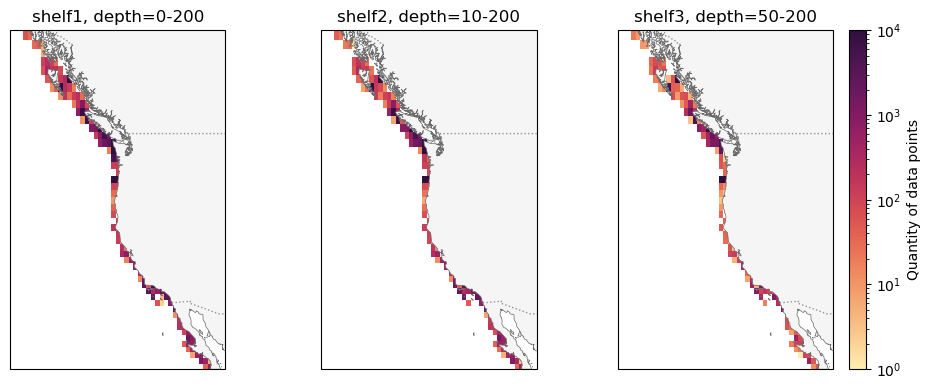

In [15]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-138, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

##########
# shelf1 #
##########
ax[0].set_title("shelf1, depth=0-200")

lon = shelf1['longitude (degrees_east)']
lat = shelf1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


##########
# shelf2 #
##########
ax[1].set_title("shelf2, depth=10-200")

lon = shelf2['longitude (degrees_east)']
lat = shelf2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


##########
# shelf3 #
##########
ax[2].set_title("shelf3, depth=50-200")

lon = shelf3['longitude (degrees_east)']
lat = shelf3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

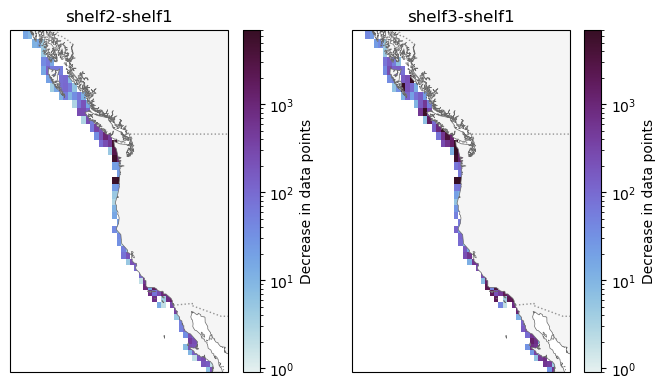

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 7000,1

#################
# shelf2-shelf1 #
#################
ax[0].set_title("shelf2-shelf1")

hist=hist1-hist2

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

#################
# shelf3-shelf1 #
#################
ax[1].set_title("shelf3-shelf1")

hist=hist1-hist3

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
4) 0.0448 +/- 0.0271, span=40.0 years
7) 0.033 +/- 0.0123, span=72.0 years
8) 0.0539 +/- 0.015, span=72.0 years
range 2 (green)
7) 0.0235 +/- 0.0088, span=72.0 years
8) 0.0304 +/- 0.0133, span=72.0 years
range 3 (red)
3) 0.0103 +/- 0.0079, span=52.0 years
7) 0.0148 +/- 0.0066, span=72.0 years
8) 0.0189 +/- 0.0123, span=71.0 years


salinity (g kg-1)
range 1 (violet)
1) -0.0058 +/- 0.0046, span=58.0 years
3) 0.0062 +/- 0.0033, span=91.0 years
7) -0.002 +/- 0.0016, span=72.0 years
8) -0.0024 +/- 0.0017, span=72.0 years
range 2 (green)
7) -0.0024 +/- 0.0016, span=72.0 years
8) -0.0036 +/- 0.0016, span=72.0 years
range 3 (red)
1) 0.012 +/- 0.0064, span=58.0 years
4) -0.0048 +/- 0.0016, span=72.0 years
7) -0.0026 +/- 0.0014, span=72.0 years
8) -0.0049 +/- 0.0021, span=71.0 years
9) 0.004 +/- 0.003, span=67.0 years


spice
range 1 (violet)
3) 0.0048 +/- 0.0034, span=52.0 years
4) 0.0042 +/- 0.0033, span=40.0 years
5) 0.0027 +/- 0.0023, span=67.0 years
7) 0

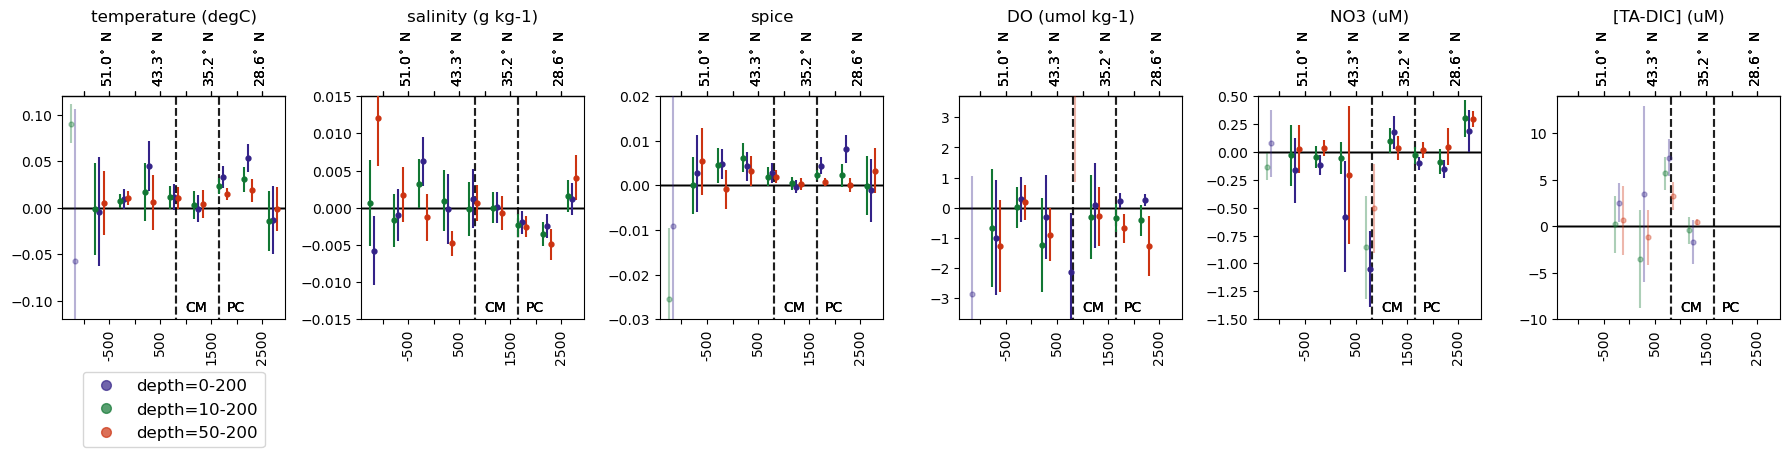

In [40]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(shelf1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(shelf2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(shelf3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')


# # build legend handles    
legend_handles = []
inlegend = ["depth=0-200",'depth=10-200','depth=50-200']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()

### Salinity

In [54]:
# the main option for the shelf has already been defined
shelf1 = obs[obs['current'] == 'shelf']
shelf1['dist'] = shelf1.NSdist

# what makes sense to play around with here is the brackish salinity cutoff, going more stringent +0.2 and +0.4 g/kg 
# range 2 -> salinity >= 31.7 
# range 3 -> salinity >= 31.9

# both within the current shelf definition
shelf2 = shelf1[(shelf1['salinity (g kg-1)']>=31.7)]
shelf3 = shelf1[(shelf1['salinity (g kg-1)']>=31.9)]

In [ ]:
# curious about depths compared to what we test above

print(f"31.5 -> mean={np.round(np.mean(shelf1['depth (m)']),2)}, min={np.round(np.min(shelf1['depth (m)']),2)}")
print(f"31.7 -> mean={np.round(np.mean(shelf2['depth (m)']),2)}, min={np.round(np.min(shelf2['depth (m)']),2)}")
print(f"31.9 -> mean={np.round(np.mean(shelf3['depth (m)']),2)}, min={np.round(np.min(shelf3['depth (m)']),2)}")

# minor impact on depth, seems to just be removing river outflow and not surface waters at this salinity range

31.5 -> mean=47.27, min=0.0
31.7 -> mean=47.99, min=0.0
31.9 -> mean=48.99, min=0.0


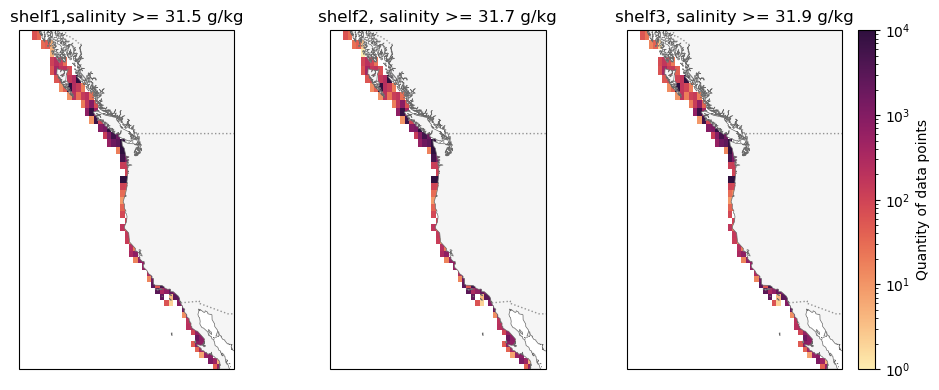

In [78]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-138, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

##########
# shelf1 #
##########
ax[0].set_title("shelf1,salinity >= 31.5 g/kg")

lon = shelf1['longitude (degrees_east)']
lat = shelf1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


##########
# shelf2 #
##########
ax[1].set_title("shelf2, salinity >= 31.7 g/kg")

lon = shelf2['longitude (degrees_east)']
lat = shelf2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


##########
# shelf3 #
##########
ax[2].set_title("shelf3, salinity >= 31.9 g/kg")

lon = shelf3['longitude (degrees_east)']
lat = shelf3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

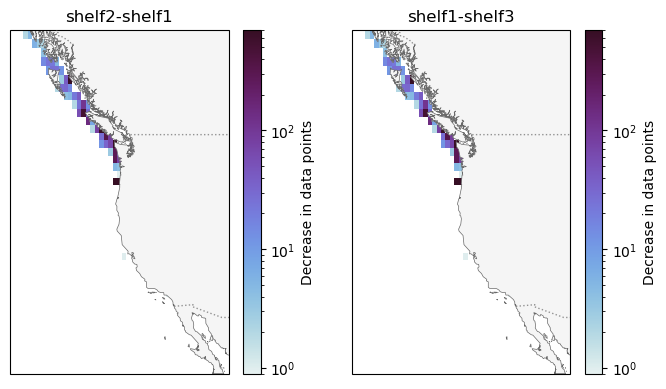

In [77]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 700,1

#############
# shelf2-shelf1 #
#############
ax[0].set_title("shelf2-shelf1")

hist=hist1-hist2

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

#############
# shelf3-shelf1 #
#############
ax[1].set_title("shelf1-shelf3")

hist=hist1-hist2
# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
4) 0.0448 +/- 0.0271, span=40.0 years
7) 0.033 +/- 0.0123, span=72.0 years
8) 0.0539 +/- 0.015, span=72.0 years
range 2 (green)
4) 0.0443 +/- 0.0267, span=40.0 years
7) 0.033 +/- 0.0123, span=72.0 years
8) 0.0539 +/- 0.015, span=72.0 years
range 3 (red)
3) 0.0103 +/- 0.0092, span=52.0 years
4) 0.0444 +/- 0.0264, span=40.0 years
7) 0.033 +/- 0.0123, span=72.0 years
8) 0.0539 +/- 0.015, span=72.0 years


salinity (g kg-1)
range 1 (violet)
1) -0.0058 +/- 0.0046, span=58.0 years
3) 0.0062 +/- 0.0033, span=91.0 years
7) -0.002 +/- 0.0016, span=72.0 years
8) -0.0024 +/- 0.0017, span=72.0 years
range 2 (green)
3) 0.0057 +/- 0.003, span=91.0 years
7) -0.002 +/- 0.0016, span=72.0 years
8) -0.0024 +/- 0.0017, span=72.0 years
range 3 (red)
1) 0.0055 +/- 0.005, span=58.0 years
3) 0.0051 +/- 0.0028, span=91.0 years
7) -0.002 +/- 0.0016, span=72.0 years
8) -0.0024 +/- 0.0017, span=72.0 years


spice
range 1 (violet)
3) 0.0048 +/- 0.0034, span=52.0 years
4) 0.0042 

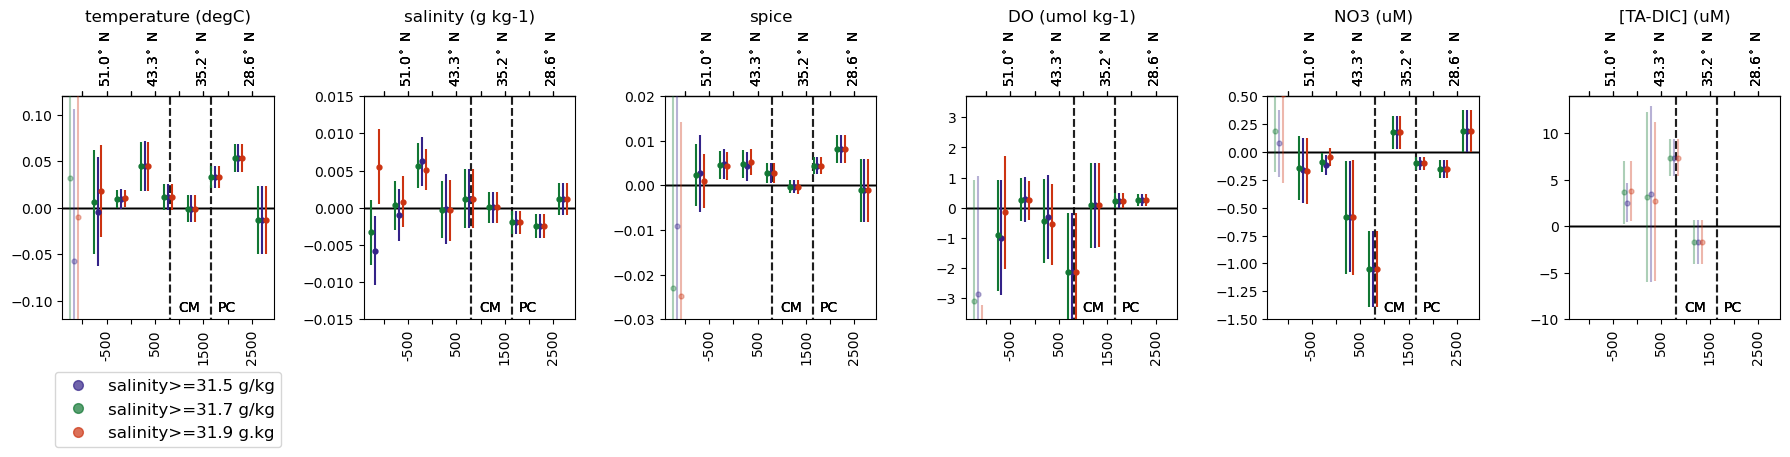

In [79]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(shelf1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(shelf2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(shelf3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')


# # build legend handles    
legend_handles = []
inlegend = ["salinity>=31.5 g/kg",'salinity>=31.7 g/kg','salinity>=31.9 g.kg']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()

## CC
100-1000 km offshore from 25-50 N, between 45 and 50 N from 100 km offshore to -145.5 E, sigma<= 26.3 kg/m3

In [93]:
# Definition of CC based on Isopycnal and geography

coastline = gpd.read_file('/ocean/ghoeven/MOAD/Data/ne_110m_land.shp')
# Define bounding box for area
bbox = box(-145.5, 20, -110.2, 60)  # lon_min, lat_min, lon_max, lat_max
# Clip the coastline to the bounding box
coastline_clipped = coastline[coastline.intersects(bbox)]
coastline_union = unary_union(coastline_clipped.geometry)

def haversine(lat1, lon1, lat2, lon2):
    """
    Computes great-circle distance between two points on Earth (in km).
    """
    R = 6371.0  # Earth radius in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

#checks if further than 100km from shore and closer than 1000km
def is_offshore100(lat, lon, coastline_geom, low_threshold_km=100, up_threshold_km=1000):
    point = Point(lon, lat)
    
    # Get nearest point on coastline boundary
    boundary = coastline_geom.boundary
    nearest_point = boundary.interpolate(boundary.project(point))
    
    # Use Haversine instead of geopy
    dist_km = haversine(lat, lon, nearest_point.y, nearest_point.x)
    return (dist_km > low_threshold_km) & (dist_km < up_threshold_km)

def CC_data(obs,*,sigma=26.3,low_threshold_km=100,up_threshold_km=1000,biflat_min=45,biflat_max=50):

    obs_copy = obs.copy()
    obs_copy['is_offshore100'] = obs.apply(
        lambda row: is_offshore100(
            row['latitude (degrees_north)'],
            row['longitude (degrees_east)'],
            coastline_union,
            low_threshold_km=low_threshold_km, 
            up_threshold_km=up_threshold_km
        ),
        axis=1
    )
    base_offshore = obs_copy['is_offshore100']

    # Points between 45–50°N, farther offshore (west) out to -145.5E
    lat = obs['latitude (degrees_north)']
    lon = obs['longitude (degrees_east)']

    extra_offshore = (
        (lat >= biflat_min) &
        (lat <= biflat_max) &
        (lon >= -145.5) &
        (lon < -133) 
    )

    offshore_sel = base_offshore | extra_offshore

    # Selecting data
    mask = (
        (obs['current'] != 'shelf') &
        (lat <= biflat_max) &                 
        (obs['sigma0 (kg m-3)'] <= sigma) & 
        offshore_sel
    )

    return obs[mask]

def cc_dist(NS, EW): # CC dist line function
    abs_a = NS.abs()
    abs_b = EW.abs()

    dist = np.select(
        [
            abs_a < abs_b,       # a closer to zero
            abs_b < abs_a,       # b closer to zero
            abs_a.isna(),        # a NaN, take b
            abs_b.isna()         # b NaN, take a
        ],
        [
            NS,
            EW,
            EW,
            NS
        ],
        default=np.nan
    )

    # and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
    dist[NS<0] = EW[NS<0]
    return dist

### Distance from shore

In [94]:
# the main option for the CC has already been defined
cc1 = obs[obs['current'] == 'CC']
cc1['dist']=cc_dist(cc1.NSdist, cc1.EWdist)

# what makes sense to play around with here is if we started the CC definition further from the shore
# 1st cutoff = range 2 = 200 km 
# 2nd cutoff = range 3 = 300 km

# since these are within the current shelf bounds we can work with the shelf1 dataset
cc2 = CC_data(obs,low_threshold_km=200)
cc2['dist']=cc_dist(cc2.NSdist, cc2.EWdist)

cc3 = CC_data(obs,low_threshold_km=300)
cc3['dist']=cc_dist(cc3.NSdist, cc3.EWdist)

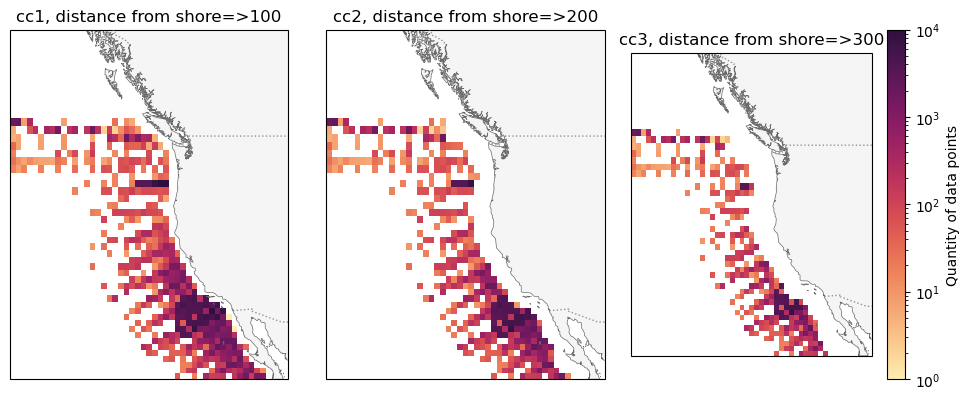

In [95]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-145, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

#######
# cc1 #
#######
ax[0].set_title("cc1, distance from shore=>100")

lon = cc1['longitude (degrees_east)']
lat = cc1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc2 #
#######
ax[1].set_title("cc2, distance from shore=>200")

lon = cc2['longitude (degrees_east)']
lat = cc2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc3 #
#######
ax[2].set_title("cc3, distance from shore=>300")

lon = cc3['longitude (degrees_east)']
lat = cc3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

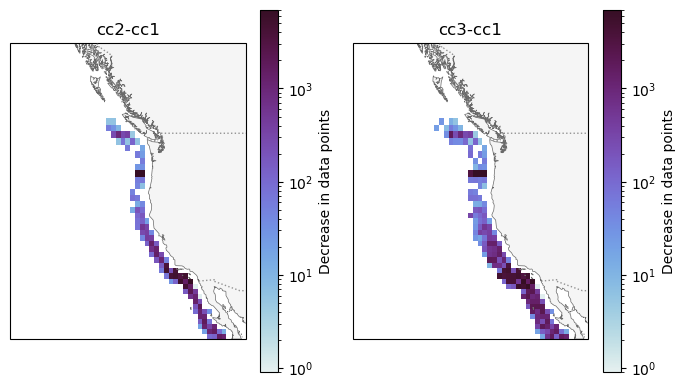

In [96]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 7000,1

###########
# cc2-cc1 #
###########
ax[0].set_title("cc2-cc1")

hist=hist1-hist2

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

###########
# cc3-cc1 #
###########
ax[1].set_title("cc3-cc1")

hist=hist1-hist3

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 2 (green)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0149 +/- 0.0132, span=63.0 years
6) 0.0101 +/- 0.0085, span=73.0 years
7) 0.0088 +/- 0.0085, span=73.0 years
range 3 (red)
1) 0.0563 +/- 0.0297, span=53.0 years
3) 0.032 +/- 0.0205, span=75.0 years
9) 0.0349 +/- 0.0313, span=36.0 years


salinity (g kg-1)
range 1 (violet)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 +/- 0.0028, span=52.0 years
3) -0.0052 +/- 0.0016, span=75.0 years
7) -0.0015 +/- 0.0014, span=73.0 years
range 2 (green)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 +/- 0.0028, span=52.0 years
3) -0.0048 +/- 0.0018, span=75.0 years
range 3 (red)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 +/- 0.0028, span=52.0 years
3) -0.0056 +/- 0.0018, spa

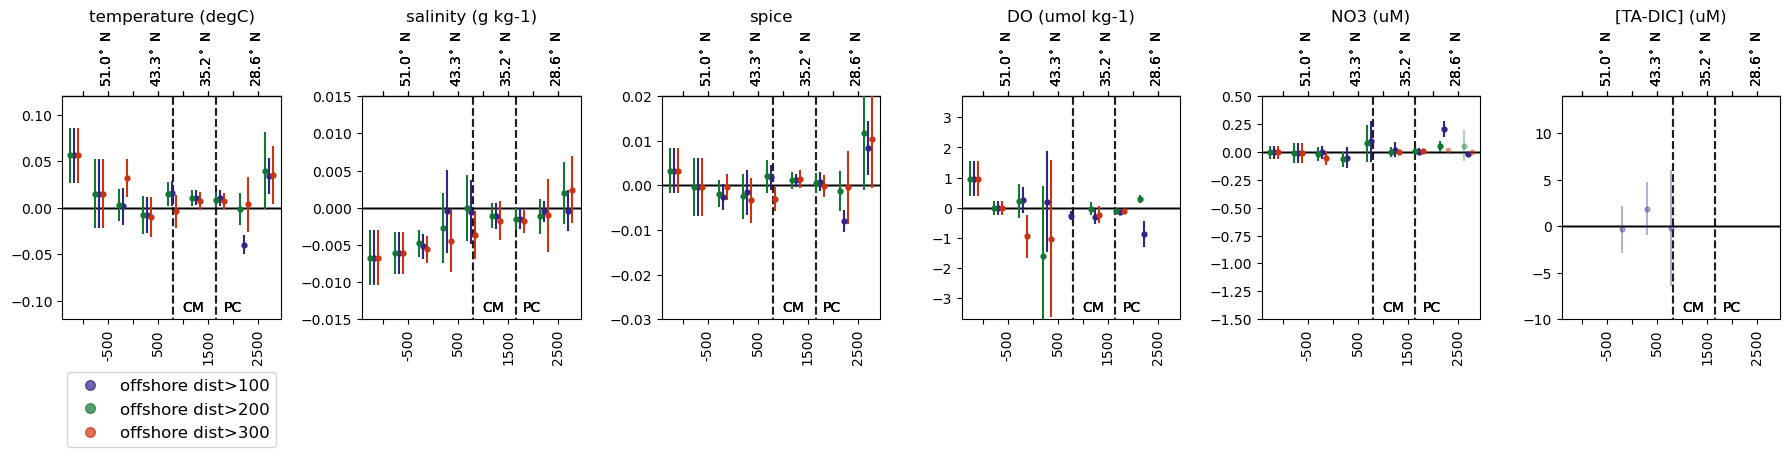

In [97]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(cc1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')


# # build legend handles    
legend_handles = []
inlegend = ["offshore dist>100",'offshore dist>200','offshore dist>300']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()

### Distance Offshore

In [98]:
# if we ended the CC definition at different distances offshore 
# original = 1000 km
# 1st cutoff = range 2 = 800 km 
# 2nd cutoff = range 3 = 1200 km

# since these are within the current shelf bounds we can work with the shelf1 dataset
cc2 = CC_data(obs,up_threshold_km=1200)
cc2['dist']=cc_dist(cc2.NSdist, cc2.EWdist)

cc3 = CC_data(obs,up_threshold_km=800)
cc3['dist']=cc_dist(cc3.NSdist, cc3.EWdist)

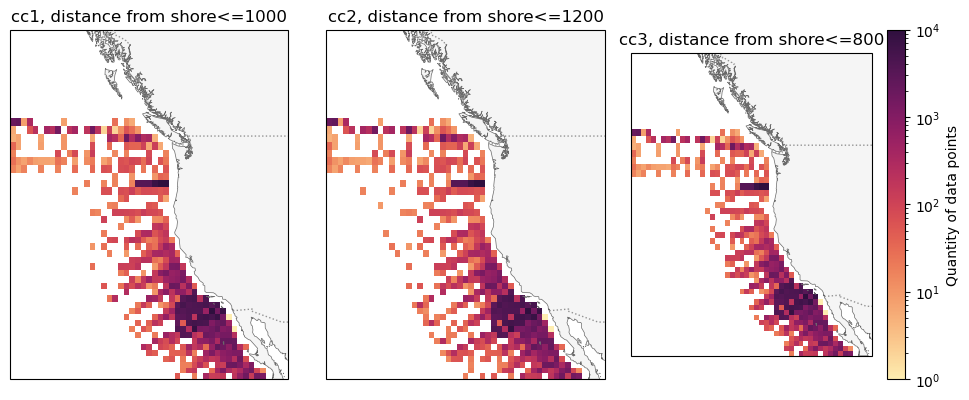

In [99]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-145, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

#######
# cc1 #
#######
ax[0].set_title("cc1, distance from shore<=1000")

lon = cc1['longitude (degrees_east)']
lat = cc1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc2 #
#######
ax[1].set_title("cc2, distance from shore<=1200")

lon = cc2['longitude (degrees_east)']
lat = cc2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc3 #
#######
ax[2].set_title("cc3, distance from shore<=800")

lon = cc3['longitude (degrees_east)']
lat = cc3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

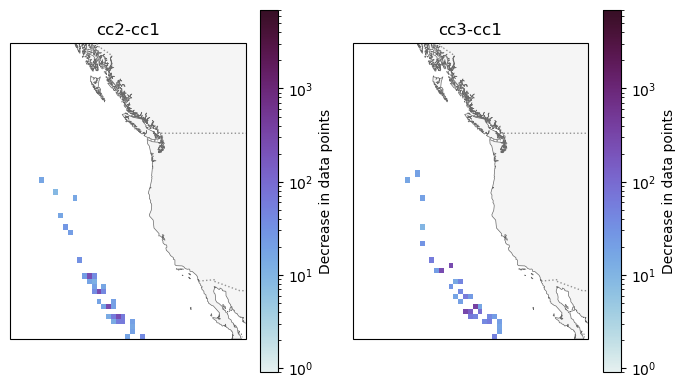

In [100]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 7000,1

###########
# cc2-cc1 #
###########
ax[0].set_title("cc2-cc1")

hist=hist2-hist1

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

###########
# cc3-cc1 #
###########
ax[1].set_title("cc3-cc1")

hist=hist1-hist3

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 2 (green)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 3 (red)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years


salinity (g kg-1)
range 1 (violet)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 +/- 0.0028, span=52.0 years
3) -0.0052 +/- 0.0016, span=75.0 years
7) -0.0015 +/- 0.0014, span=73.0 years
range 2 (green)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 

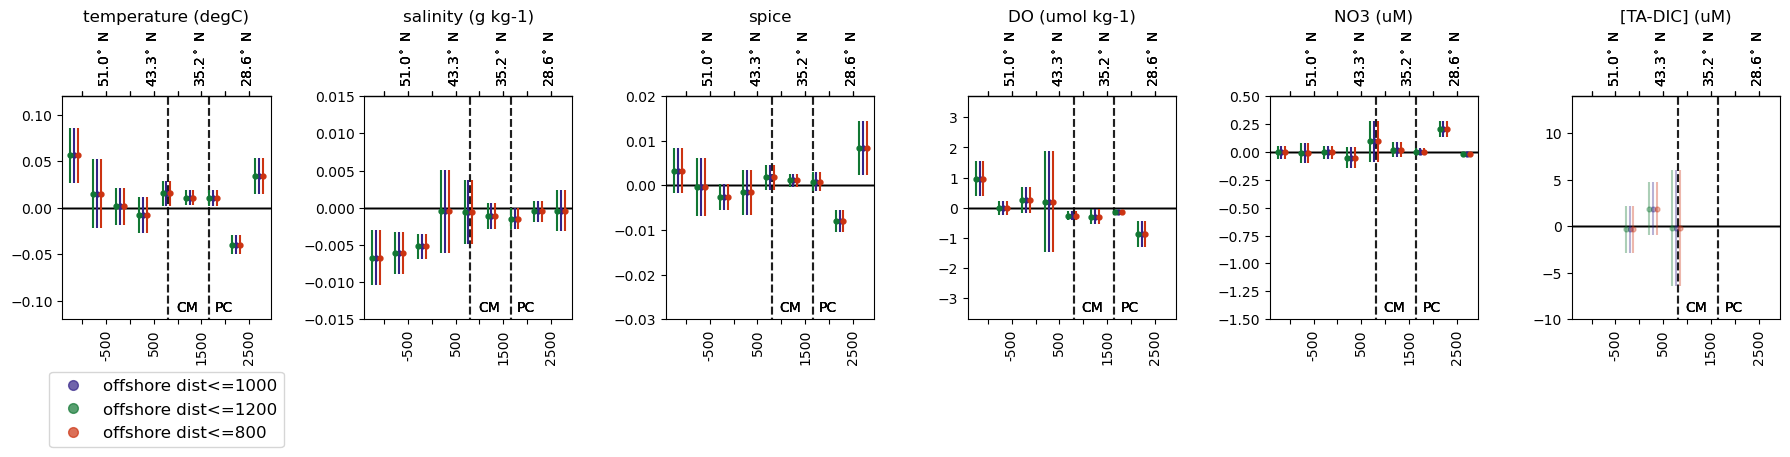

In [101]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(cc1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')


# # build legend handles    
legend_handles = []
inlegend = ["offshore dist<=1000",'offshore dist<=1200','offshore dist<=800']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()

### Density

In [103]:
# if set the CC sigma cutoff differently
# original = 26.3 
# range 2 = 26.2
# range 3 = 26.4

# since these are within the current shelf bounds we can work with the shelf1 dataset
cc2 = CC_data(obs,sigma=26.2)
cc2['dist']=cc_dist(cc2.NSdist, cc2.EWdist)

cc3 = CC_data(obs,sigma=26.4)
cc3['dist']=cc_dist(cc3.NSdist, cc3.EWdist)

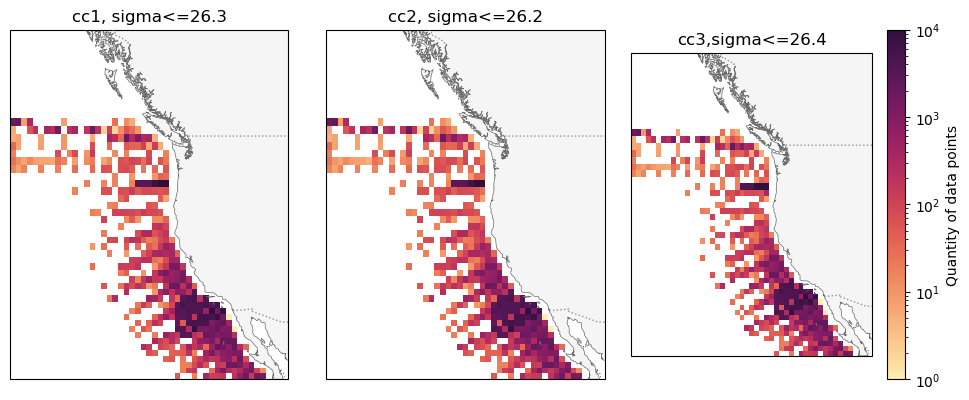

In [104]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-145, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

#######
# cc1 #
#######
ax[0].set_title("cc1, sigma<=26.3")

lon = cc1['longitude (degrees_east)']
lat = cc1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc2 #
#######
ax[1].set_title("cc2, sigma<=26.2")

lon = cc2['longitude (degrees_east)']
lat = cc2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc3 #
#######
ax[2].set_title("cc3,sigma<=26.4")

lon = cc3['longitude (degrees_east)']
lat = cc3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

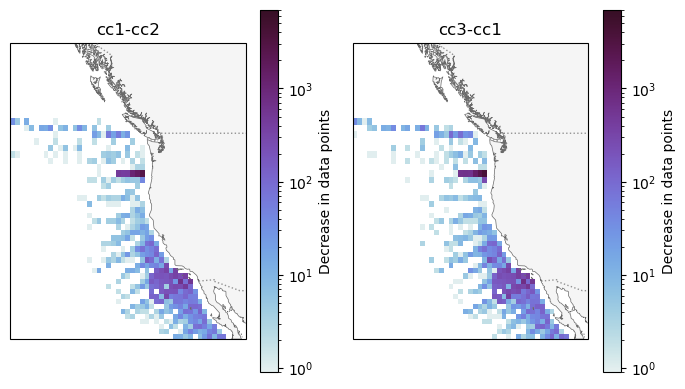

In [105]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 7000,1

###########
# cc2-cc1 #
###########
ax[0].set_title("cc1-cc2")

hist=hist1-hist2

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

###########
# cc3-cc1 #
###########
ax[1].set_title("cc3-cc1")

hist=hist3-hist1

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 2 (green)
1) 0.0566 +/- 0.0299, span=53.0 years
5) 0.0176 +/- 0.0137, span=68.0 years
6) 0.009 +/- 0.008, span=73.0 years
7) 0.0103 +/- 0.009, span=73.0 years
8) -0.0357 +/- 0.0103, span=73.0 years
9) 0.0313 +/- 0.0193, span=68.0 years
range 3 (red)
1) 0.0563 +/- 0.0298, span=53.0 years
5) 0.0165 +/- 0.0142, span=68.0 years
6) 0.011 +/- 0.0084, span=73.0 years
7) 0.0116 +/- 0.0088, span=73.0 years
8) -0.0405 +/- 0.0097, span=73.0 years
9) 0.034 +/- 0.0192, span=68.0 years


salinity (g kg-1)
range 1 (violet)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 +/- 0.0028, span=52.0 years
3) -0.0052 +/- 0.0016, span=75.0 years
7) -0.0015 +/- 0.0014, span=73.0 years
range 2 (green)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.00

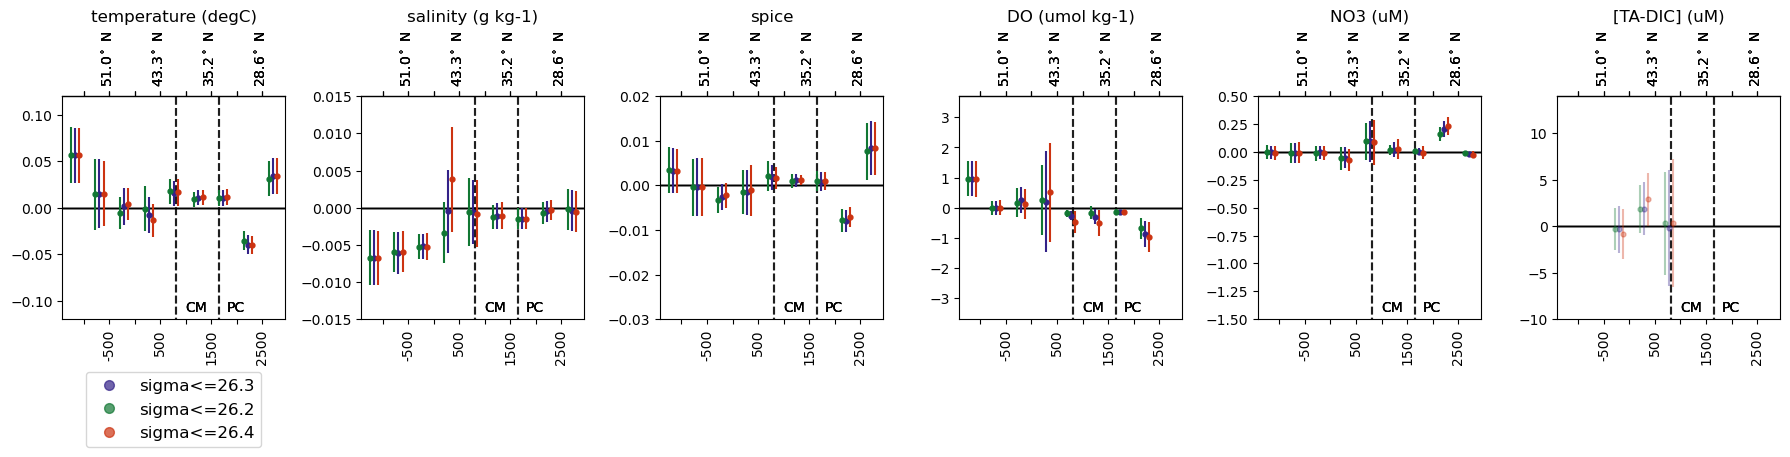

In [106]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(cc1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')


# # build legend handles    
legend_handles = []
inlegend = ["sigma<=26.3",'sigma<=26.2','sigma<=26.4']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()

### Bifurcation Band Width

In [107]:
# if set the CC sigma cutoff differently
# original = 45-50 
# thinner, range 2 = 46-49
# thicker, range 3 = 44-51

# since these are within the current shelf bounds we can work with the shelf1 dataset
cc2 = CC_data(obs,biflat_max=49,biflat_min=46)
cc2['dist']=cc_dist(cc2.NSdist, cc2.EWdist)

cc3 = CC_data(obs,biflat_max=51,biflat_min=44)
cc3['dist']=cc_dist(cc3.NSdist, cc3.EWdist)

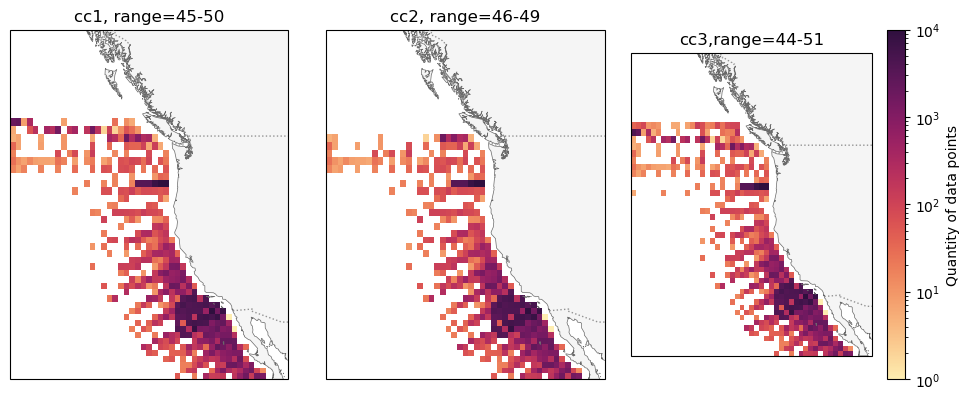

In [108]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-145, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

#######
# cc1 #
#######
ax[0].set_title("cc1, range=45-50")

lon = cc1['longitude (degrees_east)']
lat = cc1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc2 #
#######
ax[1].set_title("cc2, range=46-49")

lon = cc2['longitude (degrees_east)']
lat = cc2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc3 #
#######
ax[2].set_title("cc3,range=44-51")

lon = cc3['longitude (degrees_east)']
lat = cc3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

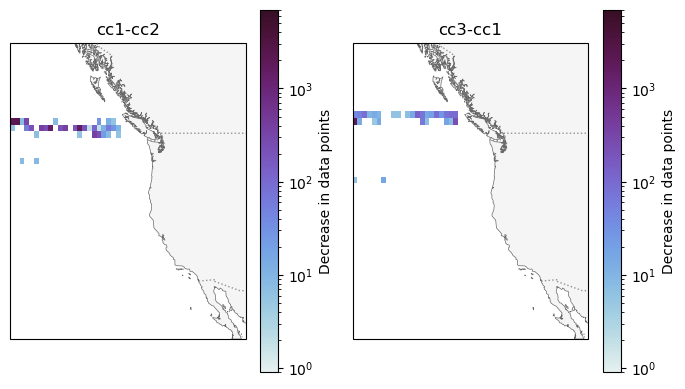

In [109]:
fig, ax = plt.subplots(1,2,figsize=(7,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

vmin,vmax = 7000,1

###########
# cc2-cc1 #
###########
ax[0].set_title("cc1-cc2")

hist=hist1-hist2

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Decrease in data points")

###########
# cc3-cc1 #
###########
ax[1].set_title("cc3-cc1")

hist=hist3-hist1

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist.T, cmap=cm.cm.dense, vmin=vmin, vmax=vmax,norm='log', transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[1], location='right',orientation='vertical',label="Decrease in data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 2 (green)
2) 0.0709 +/- 0.0481, span=51.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 3 (red)
1) 0.0559 +/- 0.0316, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years


salinity (g kg-1)
range 1 (violet)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 +/- 0.0028, span=52.0 years
3) -0.0052 +/- 0.0016, span=75.0 years
7) -0.0015 +/- 0.0014, span=73.0 years
range 2 (green)
2) -0.0048 +/- 0.0022, span=51.0 years
3) -0.0051 

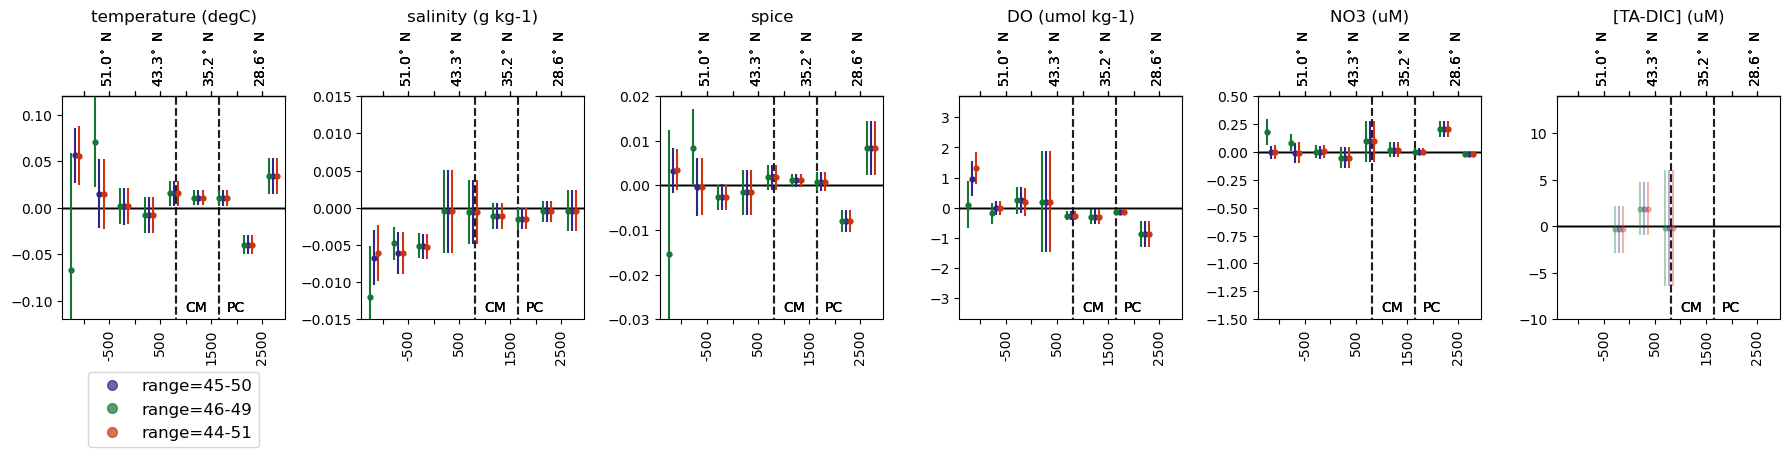

In [110]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(cc1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')


# # build legend handles    
legend_handles = []
inlegend = ["range=45-50",'range=46-49','range=44-51']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()

### Bifurcation position

In [111]:
# if set the CC sigma cutoff differently
# original = 45-50 
# north, range 2 = 46-51
# south, range 3 = 44-49

# since these are within the current shelf bounds we can work with the shelf1 dataset
cc2 = CC_data(obs,biflat_max=51,biflat_min=46)
cc2['dist']=cc_dist(cc2.NSdist, cc2.EWdist)

cc3 = CC_data(obs,biflat_max=49,biflat_min=44)
cc3['dist']=cc_dist(cc3.NSdist, cc3.EWdist)

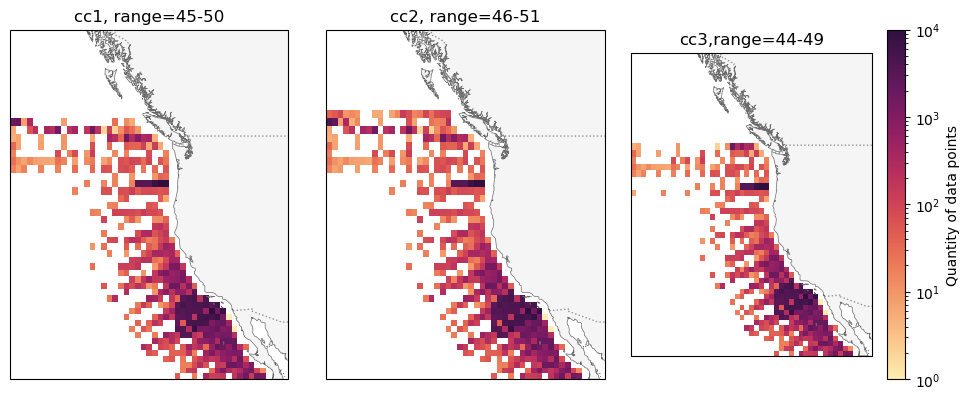

In [112]:
# plot extent

############
# ALL MAPS #
############

xlim, ylim = [-145, -110.2], [25, 57]
proj= crs.Mercator(np.mean(xlim), *ylim)
fig, ax = plt.subplots(1,3,figsize=(10,4),subplot_kw={'projection': proj})

for axs in ax:
    # Make plot area
    axs.set_extent(xlim + ylim)
    # Draw coastline
    axs.add_feature(feature.GSHHSFeature('low', edgecolor='dimgray', facecolor='whitesmoke', lw=0.5), zorder=2)
    # add canada USA border
    axs.add_feature(feature.BORDERS, linestyle='dotted', edgecolor='dimgray', alpha=0.7, zorder=3)

xbin = np.linspace(xlim[0],xlim[1],50)
ybin = np.linspace(ylim[0],ylim[1],50)
vmin,vmax = 1,10000

#######
# cc1 #
#######
ax[0].set_title("cc1, range=45-50")

lon = cc1['longitude (degrees_east)']
lat = cc1['latitude (degrees_north)']

# Create 2D histogram
hist1, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Convert bin edges to meshgrid
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)
# only need to do this once bc bins are the same for all three plots

# Plot using pcolormesh
pcm = ax[0].pcolormesh(X, Y, hist1.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc2 #
#######
ax[1].set_title("cc2, range=46-51")

lon = cc2['longitude (degrees_east)']
lat = cc2['latitude (degrees_north)']

# Create 2D histogram
hist2, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[1].pcolormesh(X, Y, hist2.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
# fig.colorbar(pcm, ax=ax[0], location='right',orientation='vertical',label="Quantity of data points")


#######
# cc3 #
#######
ax[2].set_title("cc3,range=44-49")

lon = cc3['longitude (degrees_east)']
lat = cc3['latitude (degrees_north)']

# Create 2D histogram
hist3, xedges, yedges = np.histogram2d(lon, lat, bins=[xbin,ybin])

# Plot using pcolormesh
pcm = ax[2].pcolormesh(X, Y, hist3.T, cmap=cm.cm.matter, norm='log', vmin=vmin, vmax=vmax, transform=crs.PlateCarree())
fig.colorbar(pcm, ax=ax[2], location='right',orientation='vertical',label="Quantity of data points")

plt.tight_layout()

temperature (degC)
range 1 (violet)
1) 0.0563 +/- 0.0297, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 2 (green)
1) 0.0559 +/- 0.0316, span=53.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years
range 3 (red)
2) 0.0709 +/- 0.0481, span=51.0 years
5) 0.0156 +/- 0.0136, span=68.0 years
6) 0.0107 +/- 0.0082, span=73.0 years
7) 0.0104 +/- 0.009, span=73.0 years
8) -0.0399 +/- 0.01, span=73.0 years
9) 0.034 +/- 0.0191, span=68.0 years


salinity (g kg-1)
range 1 (violet)
1) -0.0067 +/- 0.0037, span=53.0 years
2) -0.0061 +/- 0.0028, span=52.0 years
3) -0.0052 +/- 0.0016, span=75.0 years
7) -0.0015 +/- 0.0014, span=73.0 years
range 2 (green)
1) -0.0061 +/- 0.0038, span=53.0 years
2) -0.0061 

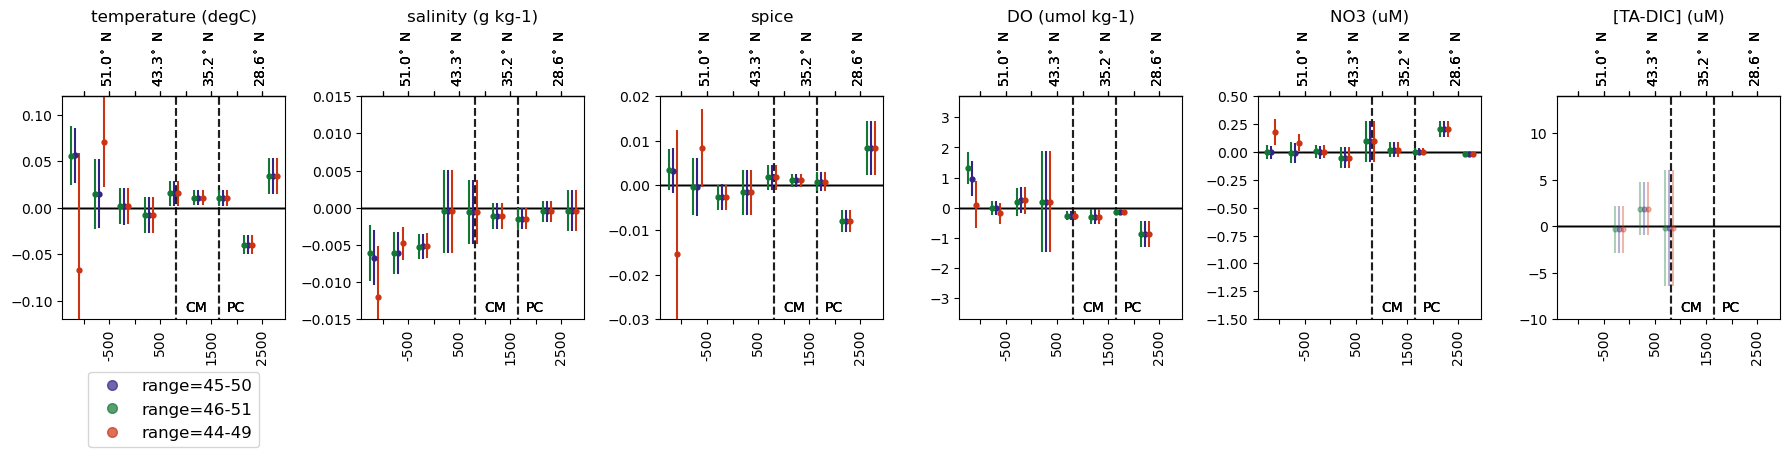

In [113]:
# now looking at how trends change with this new definition
varstrings = ['temperature (degC)','salinity (g kg-1)', 'spice',
       'DO (umol kg-1)', 'NO3 (uM)','[TA-DIC] (uM)']

fig,ax = plt.subplots(1,len(varstrings),figsize=[3*len(varstrings),5])

for i in range(len(varstrings)):
    print(varstrings[i])

    ax[i].set_title(varstrings[i])
    slopes, yerr, span = plot_ratediff_NS_CI(cc1,varstrings[i], ax[i], '#332288')
    print('range 1 (violet)')
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 2 (green)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc2,varstrings[i], ax[i], '#117733',offset=-80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('range 3 (red)')
    slopes, yerr, span = plot_ratediff_NS_CI(cc3,varstrings[i], ax[i], '#CC3311',offset=80)
    for j in range(len(slopes)):
        if (abs(slopes[j]) > yerr[j]) and span[j] > 30: 
            print(f"{j+1}) {np.round(slopes[j],4)} +/- {np.round(yerr[j],4)}, span={span[j]} years")

    print('\n')


# # build legend handles    
legend_handles = []
inlegend = ["range=45-50",'range=46-51','range=44-49']
colours = ['#332288', '#117733', '#CC3311']
markers = ['o','o','o']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
ax[0].legend(handles=legend_handles, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=12)

plt.tight_layout()